# Library

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Dataset

In [4]:
!unzip "/content/45fitur_dataset.zip" -d "/content/45fitur_dataset"

Streaming output truncated to the last 5000 lines.
   creating: /content/45fitur_dataset/test/sate-ayam-madura/
   creating: /content/45fitur_dataset/test/sate-lilit/
   creating: /content/45fitur_dataset/test/sate-maranggi/
   creating: /content/45fitur_dataset/test/soerabi/
   creating: /content/45fitur_dataset/test/soto-ayam-lamongan/
   creating: /content/45fitur_dataset/test/tahu-telur/
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_7231_jpg.rf.9ec3b49e1ceaf3be19aca2966886bf93.jpg  
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_7233_jpg.rf.564ced4dd0660cc1c9bd4103abcd7e58.jpg  
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_7223_jpg.rf.23ae2dc1f87909488ae1c991a4f3bad8.jpg  
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_7399_jpg.rf.95716e7de839525262b1df1ce14a482b.jpg  
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_7390_jpg.rf.81c8347068d65024a4f320590e20bb5b.jpg  
  inflating: /content/45fitur_dataset/test/kue-lumpur/IMG_74

# Distribusi

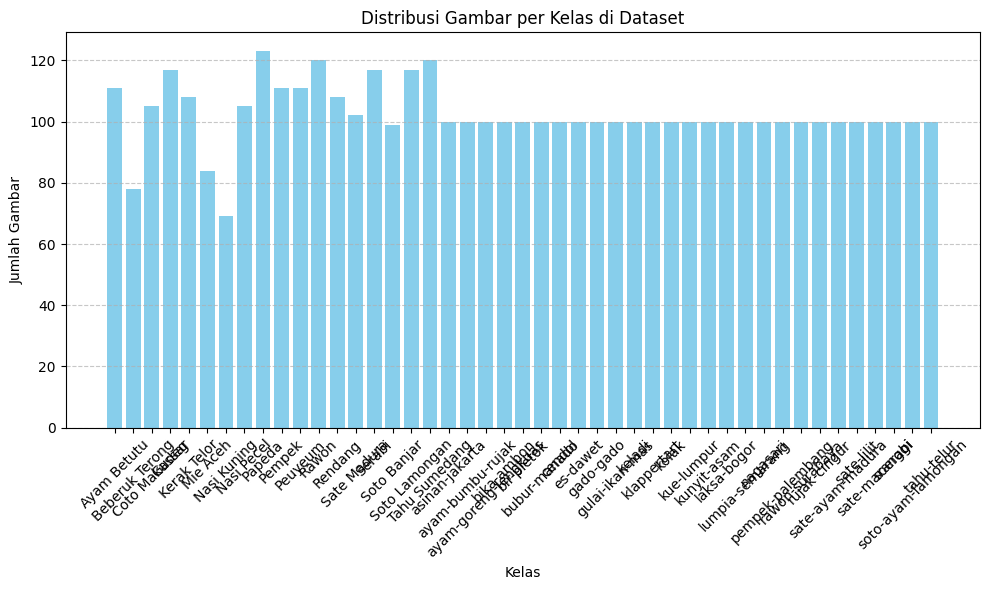

In [5]:
combined_dir = "/content/45fitur_dataset/train"

class_names = sorted(os.listdir(combined_dir))
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(combined_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Plot distribusi
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribusi Gambar per Kelas di Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Preprocessing dan Load

In [6]:
batch_size = 32

train_dir = "/content/45fitur_dataset/train"
val_dir = "/content/45fitur_dataset/valid"
test_dir = "/content/45fitur_dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4605 images belonging to 45 classes.
Found 314 images belonging to 45 classes.
Found 344 images belonging to 45 classes.


# Model Transfer Learning

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_3 = Model(inputs=base_model.input, outputs=output)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training dan Evaluasi Model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Image generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory='/content/45fitur_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='/content/45fitur_dataset/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Training model
history = model_3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stop]
)


Found 4605 images belonging to 45 classes.
Found 314 images belonging to 45 classes.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.3833 - loss: 2.5650 - val_accuracy: 0.8503 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8458 - loss: 0.5559 - val_accuracy: 0.8917 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9118 - loss: 0.3172 - val_accuracy: 0.9108 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9342 - loss: 0.2232 - val_accuracy: 0.9172 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9533 - loss: 0.1597 - val_accuracy: 0.9299 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9537 - loss: 0.1591 - val_accuracy: 0.9490 - val_loss: 0.2360 - learning_rate: 0.0010
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9718 - loss: 0.110

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/content/45fitur_dataset/test',  # path ke folder test
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi model pada data test
test_loss, test_acc = model_3.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


Found 344 images belonging to 45 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.9699 - loss: 0.1137
Test loss: 0.0546
Test accuracy: 0.9855


In [10]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
test_loss, test_accuracy = model_3.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9699 - loss: 0.1137
Test Accuracy: 98.55%
Training Accuracy: 98.61%
Validation Accuracy: 95.22%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9699 - loss: 0.1137


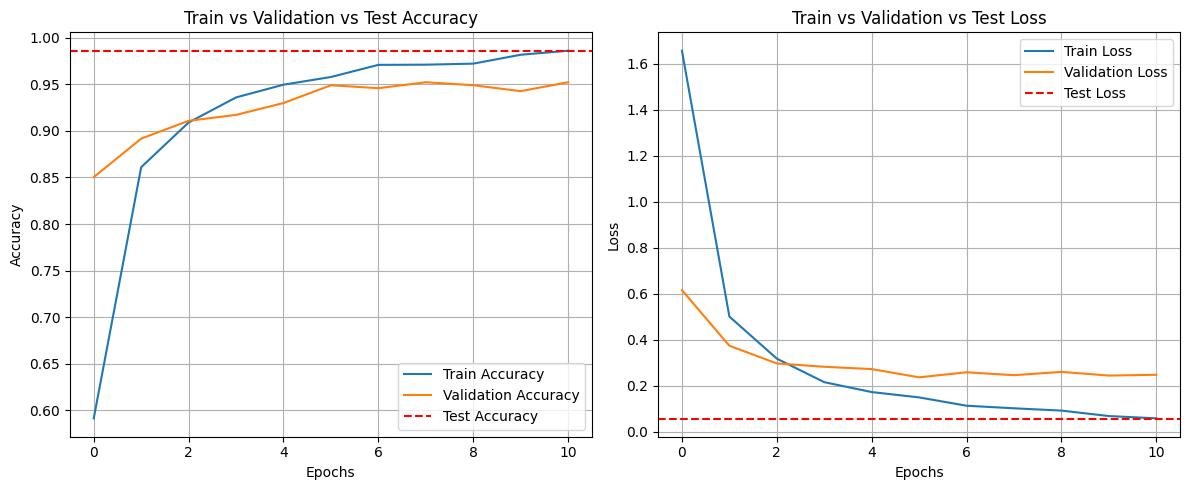

In [11]:
import matplotlib.pyplot as plt

# Ambil test accuracy dan test loss
test_loss, test_accuracy = model_3.evaluate(test_generator)

# Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('Train vs Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Train vs Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
y_pred_probs = model_3.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels dari test generator
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step
                      precision    recall  f1-score   support

         Ayam Betutu       1.00      1.00      1.00         8
      Beberuk Terong       1.00      1.00      1.00         4
       Coto Makassar       1.00      1.00      1.00         3
               Gudeg       1.00      0.80      0.89         5
         Kerak Telor       1.00      0.67      0.80         3
            Mie Aceh       1.00      1.00      1.00         4
         Nasi Kuning       1.00      1.00      1.00         4
          Nasi Pecel       1.00      1.00      1.00         7
              Papeda       1.00      1.00      1.00         3
              Pempek       0.75      0.75      0.75         4
             Peuyeum       1.00      1.00      1.00         2
               Rawon       1.00      1.00      1.00         5
             Rendang       1.00      1.00      1.00         9
         Sate Madura       0.90      1.00      0.95         9
              Serabi       1

# Interference

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


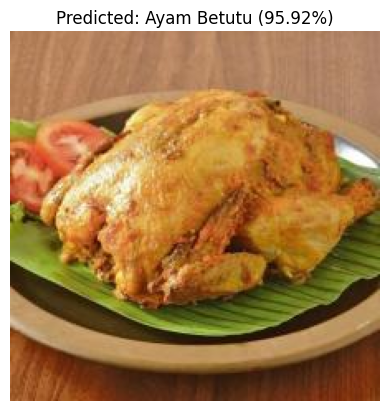

Image: Ayam-Betutu-55_jpg.rf.d882d30ac3b5c6c301e52b9829d468be.jpg
Predicted Label: Ayam Betutu
Confidence: 95.92%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


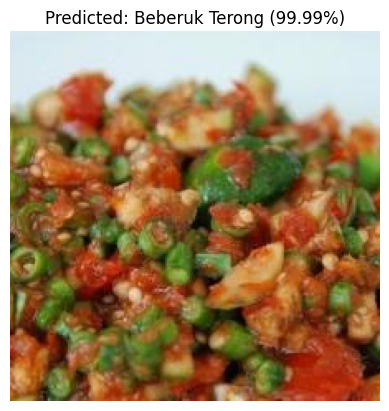

Image: Beberuk-Terong-4_jpg.rf.a22d07a3a8c02d40455a8b31ab910c16.jpg
Predicted Label: Beberuk Terong
Confidence: 99.99%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


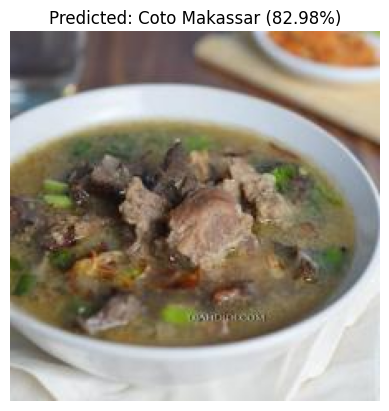

Image: CotoMakassar-47_jpg.rf.5df814b39d1757f213f2bbff9107a20f.jpg
Predicted Label: Coto Makassar
Confidence: 82.98%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


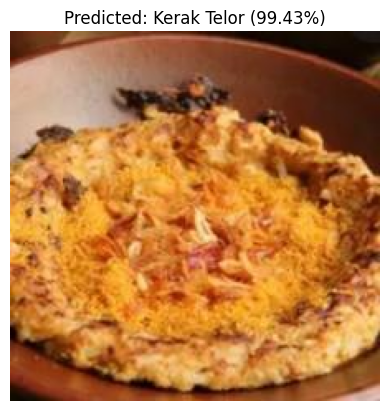

Image: kerak-telor-5_jpg.rf.9eb1a93d5f72923b0321bb5368148676.jpg
Predicted Label: Kerak Telor
Confidence: 99.43%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


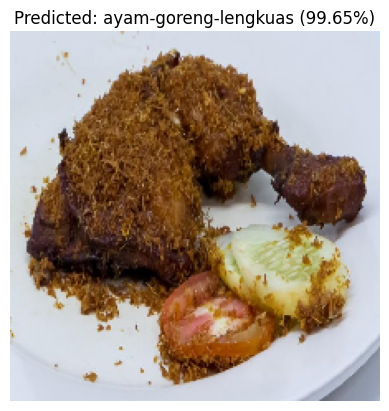

Image: IMG_8678_jpg.rf.be1b7d05573e354e2fd11133af553955.jpg
Predicted Label: ayam-goreng-lengkuas
Confidence: 99.65%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


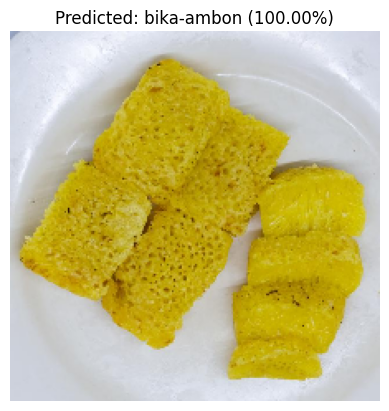

Image: IMG_7344_jpg.rf.bec159b2e98cf3a343dad4a588635d45.jpg
Predicted Label: bika-ambon
Confidence: 100.00%



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Daftar path gambar
image_paths = [
    '/content/45fitur_dataset/test/Ayam Betutu/Ayam-Betutu-55_jpg.rf.d882d30ac3b5c6c301e52b9829d468be.jpg',
    '/content/45fitur_dataset/test/Beberuk Terong/Beberuk-Terong-4_jpg.rf.a22d07a3a8c02d40455a8b31ab910c16.jpg',
    '/content/45fitur_dataset/test/Coto Makassar/CotoMakassar-47_jpg.rf.5df814b39d1757f213f2bbff9107a20f.jpg',
    '/content/45fitur_dataset/test/Kerak Telor/kerak-telor-5_jpg.rf.9eb1a93d5f72923b0321bb5368148676.jpg',
    '/content/45fitur_dataset/test/ayam-goreng-lengkuas/IMG_8678_jpg.rf.be1b7d05573e354e2fd11133af553955.jpg',
    '/content/45fitur_dataset/test/bika-ambon/IMG_7344_jpg.rf.bec159b2e98cf3a343dad4a588635d45.jpg'

]

# Ganti ini sesuai dengan label folder pada test_generator
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Loop untuk prediksi tiap gambar
for image_path in image_paths:
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model_3.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = np.max(predictions) * 100

    # Tampilkan gambar dan hasil
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%\n")
